In [1]:
!date

Thu Oct  3 15:26:05 EDT 2024


In [2]:
pwd

'/mmfs1/data/aglinska/BC-MISC-Tutorials/Python Basics'

In [3]:
import ants
import numpy as np
from matplotlib import pyplot as plt

/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
anat = ants.image_read('./Data/sub-28702/anat/sub-28702_desc-preproc_T1w.nii.gz') # reads the nifti file into ants object
brain_mask = ants.image_read('./Data/sub-28702/anat/sub-28702_desc-brain_mask.nii.gz') # reads the nifti file into ants object

# Extract the brain, this picks up from the previous tutorial in 03-ANTSpy-basics.ipynb
brain = anat.copy()
brain[brain_mask==0]=0 # Set all the parts of the image where brain_mask==0 to 0
brain

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (220, 320, 208)
	 Spacing    : (0.8, 0.8, 0.8)
	 Origin     : (88.9204, 128.4992, -65.1701)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

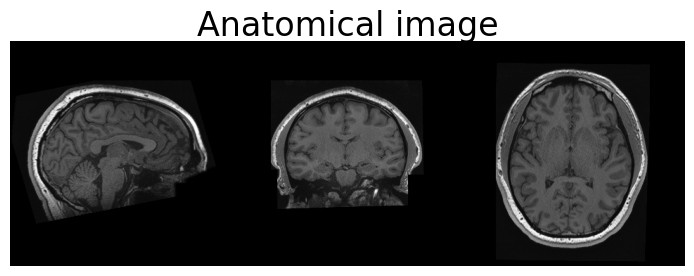

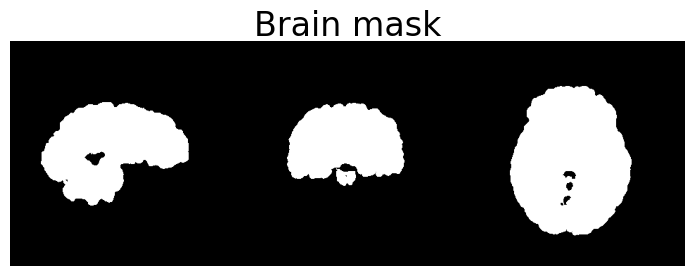

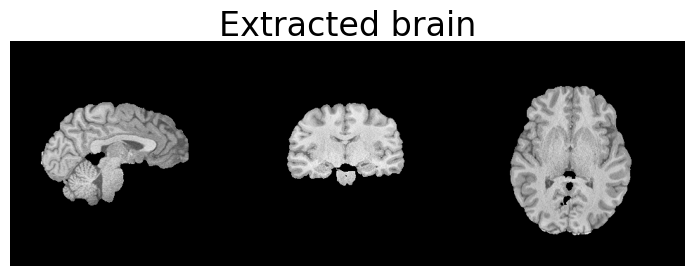

In [5]:
anat.plot_ortho(flat=True,orient_labels=False,xyz_lines=False,textfontcolor='k',title='Anatomical image')
brain_mask.plot_ortho(flat=True,orient_labels=False,xyz_lines=False,textfontcolor='k',title='Brain mask')
brain.plot_ortho(flat=True,orient_labels=False,xyz_lines=False,textfontcolor='k',title='Extracted brain')

## Registration
Common thing to do is to "coregister brains", i.e.  morph one brain in relation to another. You might want to do this for various analytical reason, for exampe to make sure that all your subjects are facing the same way and are positioned roughly similarly to one another. Let see how to do this

In [6]:
# Let's take a template brain. This could also be callled standard brain / atlas brain / reference brain
template = ants.image_read('./Data/Atlas_brain_2mm.nii') # This brain is an average brain from 152 participants commonly used in group analyses
# For more info, see https://www.bic.mni.mcgill.ca/ServicesAtlases/ICBM152NLin2009
template

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (91, 109, 91)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

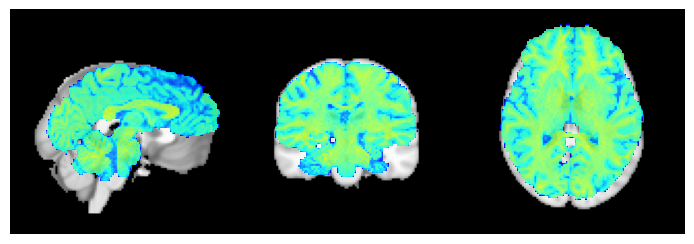

In [7]:
# Let's see how our subject's brain looks like overlayed on the template brain
template.plot_ortho((brain),flat=True,orient_labels=False,xyz_lines=False)

Seems like our subject's brain is pushed bit forward and tilted upwards compared to the reference brain

Let's fix that by Rigidly aligning the subjects brain to the reference

ants.registration is a set of tools to learn transformations from one brain to another.

It takes in the following parameters:

fixed= < the reference brain. This brain will not change >

moving= <this is the brain to change. This will be moved or morphend to match the 'fixed' brain >

type_of_transform= <string specifying the type of transform(s) to apply> here's some common ones

    'Rigid' - moves (translates) and rotates the brain

    'Affine' - Ridig plus stretches (scales) the brain to match the 'fixed'

    "SyN": Symmetric normalization: Affine + deformable transformation, with mutual information as optimization metric.

for a full list of available transforms, run "ants.registration?"

For our purpose here, we will use Rigid and store the output in a variable called transform_list

In [8]:
transform_list = ants.registration(fixed=template,moving=brain,type_of_transform='Rigid')

In [9]:
transform_list

{'warpedmovout': ANTsImage (RPI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (91, 109, 91)
 	 Spacing    : (2.0, 2.0, 2.0)
 	 Origin     : (-90.0, 126.0, -72.0)
 	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.],
 'warpedfixout': ANTsImage (LPI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (220, 320, 208)
 	 Spacing    : (0.8, 0.8, 0.8)
 	 Origin     : (88.9204, 128.4992, -65.1701)
 	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.],
 'fwdtransforms': ['/tmp/tmpubjiiikg0GenericAffine.mat'],
 'invtransforms': ['/tmp/tmpubjiiikg0GenericAffine.mat']}

Running ants.registration returns transform_list whichis a dict and has the following fields. 

Most important are: 

    'warpedmovout': this is the image after the transformations are applied
    'fwdtransforms' : these are the actual transformations that were applied to 'moving' image to get the 'warpedmovout' output

Note that applying Rigid transform (or ANTS transform) changed the size and shape of the image. Our original brain was (220, 320, 208) in size with .8mm^3 voxels

After the Ridig transform this was changed to  (91, 109, 91) 2mm^3 voxels to match the reference brain

For more info see: https://antspy.readthedocs.io/en/latest/registration.html    

In [10]:
# To get the transformed image we can use either of these methods

In [11]:
brain_transformed = transform_list['warpedmovout'] # Grab the morphed image that ANTSpy make 

In [12]:
brain_transformed = ants.apply_transforms(
    fixed=template,
    moving=brain,
    transformlist=transform_list['fwdtransforms'],
    interpolator='linear')
# Take the forward transformations learned and manually apply them to an image

In [13]:
# Both approach result in the same thing

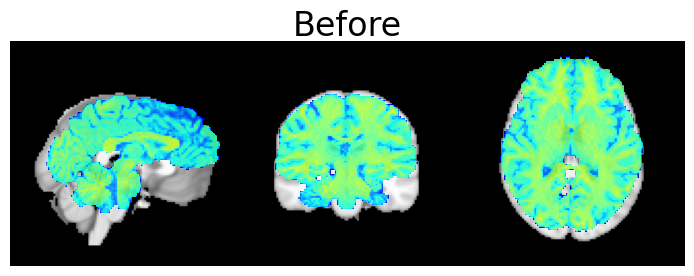

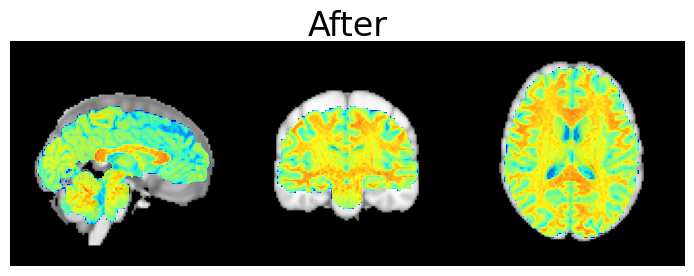

In [14]:
# Let's see what happened
template.plot_ortho(brain,flat=True,orient_labels=False,xyz_lines=False,textfontcolor='k',title='Before') # Overlaying subjects brain on a template before Rigid alignment
template.plot_ortho(brain_transformed,flat=True,orient_labels=False,xyz_lines=False,textfontcolor='k',title='After') # Overlaying subjects brain on a template after Rigid alignment

After Ridig alignment the subjects brain is better aligned with the template brain, it was tilted down and centered to better match the reference

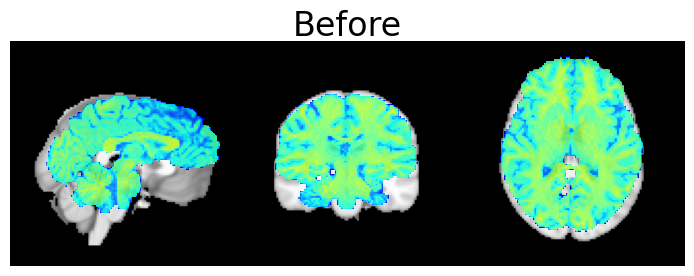

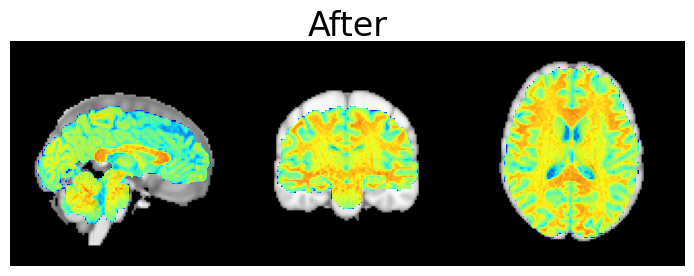

In [15]:
# If we were to use nonlinear SyN transform, then the brain would be nonlinearly deformed and each voxel would be moved to match the reference
# This better matches the reference brain, but loses the shape and size information of the individuals brain
# You migth want to use this if you want all brains to be exactly the same shape and size (maybe you're interested in corticall thickness in specific regions etc.)
transform_list2 = ants.registration(fixed=template,moving=brain,type_of_transform='SyN')
brain_transformed2 = transform_list['warpedmovout'] # Grab the morphed image that ANTSpy make 
template.plot_ortho(brain,flat=True,orient_labels=False,xyz_lines=False,textfontcolor='k',title='Before') # Overlaying subjects brain on a template before Rigid alignment
template.plot_ortho(brain_transformed2,flat=True,orient_labels=False,xyz_lines=False,textfontcolor='k',title='After') # Overlaying subjects brain on a template after Rigid alignment